/content
Cloning into 'OneFormer-Colab'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 141 (delta 35), reused 133 (delta 27), pack-reused 0
Receiving objects: 100% (141/141), 6.71 MiB | 24.35 MiB/s, done.
Resolving deltas: 100% (35/35), done.
/content/OneFormer
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
Cloning into 'detectron2'...
remote: Enumerating objects: 15238, done.
remote: Counting objects: 100% (259/259), done.
remote: Compressing objects: 100% (180/180), done.
remote: Total 15238 (delta 132), reused 167 (delta 79), pack-reused 14979
Receiving objects: 100% (15238/15238), 6.27 MiB | 18.95 MiB/s, done.
Resolving deltas: 100% (10999/10999), done.


[09/04 13:50:51 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/OneFormer/250_16_dinat_l_oneformer_ade20k_160k.pth ...


  text_encoder.positional_embedding
  text_encoder.transformer.resblocks.0.attn.{in_proj_bias, in_proj_weight}
  text_encoder.transformer.resblocks.0.attn.out_proj.{bias, weight}
  text_encoder.transformer.resblocks.0.ln_1.{bias, weight}
  text_encoder.transformer.resblocks.0.mlp.c_fc.{bias, weight}
  text_encoder.transformer.resblocks.0.mlp.c_proj.{bias, weight}
  text_encoder.transformer.resblocks.0.ln_2.{bias, weight}
  text_encoder.transformer.resblocks.1.attn.{in_proj_bias, in_proj_weight}
  text_encoder.transformer.resblocks.1.attn.out_proj.{bias, weight}
  text_encoder.transformer.resblocks.1.ln_1.{bias, weight}
  text_encoder.transformer.resblocks.1.mlp.c_fc.{bias, weight}
  text_encoder.transformer.resblocks.1.mlp.c_proj.{bias, weight}
  text_encoder.transformer.resblocks.1.ln_2.{bias, weight}
  text_encoder.transformer.resblocks.2.attn.{in_proj_bias, in_proj_weight}
  text_encoder.transformer.resblocks.2.attn.out_proj.{bias, weight}
  text_encoder.transformer.resblocks.2.ln_1

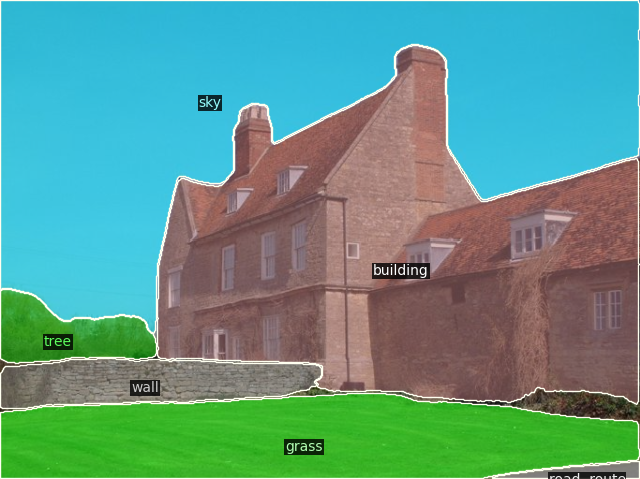

In [ ]:
#@title 1. Clone OneFormer Repo
######
%cd /content/
!rm -rf OneFormer/
!git clone https://github.com/SHI-Labs/OneFormer-Colab.git
! mv OneFormer-Colab OneFormer
%cd /content/OneFormer/

######
#@title 2. Install Dependencies.
#@markdown It may take several minutes for all installations to finish.
######

# # Install opencv (required for running the demo)
!pip3 install -U opencv-python --quiet
!pip3 install natten -f https://shi-labs.com/natten/wheels/cu113/torch1.10.1/index.html --quiet

# # # Install other dependencies
!pip3 install git+https://github.com/cocodataset/panopticapi.git --quiet
!pip3 install git+https://github.com/mcordts/cityscapesScripts.git --quiet

!pip3 install -r requirements.txt --quiet
!pip3 install ipython-autotime --quiet
!pip3 install imutils --quiet

import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])} --quiet
sys.path.insert(0, os.path.abspath('./detectron2'))

######
#@title 3. Import Libraries and other Utilities
######
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
setup_logger(name="oneformer")
import os
import subprocess
# Import libraries
import numpy as np
import cv2
import torch
from google.colab.patches import cv2_imshow
import imutils

# Import detectron2 utilities
from detectron2.config import get_cfg
from detectron2.projects.deeplab import add_deeplab_config
from detectron2.data import MetadataCatalog
from demo.defaults import DefaultPredictor
from demo.visualizer import Visualizer, ColorMode


# import OneFormer Project
from oneformer import (
    add_oneformer_config,
    add_common_config,
    add_swin_config,
    add_dinat_config,
    add_convnext_config,
)
######
#@title 4. Define helper functions
######
#Download pth file
subprocess.run('wget https://shi-labs.com/projects/oneformer/ade20k/250_16_dinat_l_oneformer_ade20k_160k.pth', shell=True)
#get image
img = cv2.imread("samples/ade20k.jpeg")
img = imutils.resize(img, width=640)
#subprocess.run('wget https://shi-labs.com/projects/oneformer/cityscapes/250_16_swin_l_oneformer_cityscapes_90k.pth', shell=True)
#define device and detaset
cpu_device = torch.device("cpu")
SWIN_CFG_DICT = {"cityscapes": "configs/cityscapes/oneformer_swin_large_IN21k_384_bs16_90k.yaml",
            "coco": "configs/coco/oneformer_swin_large_IN21k_384_bs16_100ep.yaml",
            "ade20k": "configs/ade20k/oneformer_swin_large_IN21k_384_bs16_160k.yaml",}
DINAT_CFG_DICT = {"cityscapes": "configs/cityscapes/oneformer_dinat_large_bs16_90k.yaml",
            "coco": "configs/coco/oneformer_dinat_large_bs16_100ep.yaml",
            "ade20k": "configs/ade20k/oneformer_dinat_large_IN21k_384_bs16_160k.yaml",}
def setup_cfg(dataset, model_path, use_swin):
    # load config from file and command-line arguments
    cfg = get_cfg()
    add_deeplab_config(cfg)
    add_common_config(cfg)
    add_swin_config(cfg)
    add_dinat_config(cfg)
    add_convnext_config(cfg)
    add_oneformer_config(cfg)
    if use_swin:
      cfg_path = SWIN_CFG_DICT[dataset]
    else:
      cfg_path = DINAT_CFG_DICT[dataset]
    cfg.merge_from_file(cfg_path)
    cfg.MODEL.DEVICE = 'cpu'
    cfg.MODEL.WEIGHTS = model_path
    cfg.freeze()
    return cfg

use_swin = False
cfg = setup_cfg("ade20k", "/content/OneFormer/250_16_dinat_l_oneformer_ade20k_160k.pth", use_swin)
predictor = DefaultPredictor(cfg)
metadata = MetadataCatalog.get(
    cfg.DATASETS.TEST_PANOPTIC[0] if len(cfg.DATASETS.TEST_PANOPTIC) else "__unused"
)
if 'cityscapes_fine_sem_seg_val' in cfg.DATASETS.TEST_PANOPTIC[0]:
    from cityscapesscripts.helpers.labels import labels
    stuff_colors = [k.color for k in labels if k.trainId != 255]
    metadata = metadata.set(stuff_colors=stuff_colors)

visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, instance_mode=ColorMode.IMAGE)
predictions = predictor(img, "panoptic")
panoptic_seg, segments_info = predictions["panoptic_seg"]
out = visualizer.draw_panoptic_seg_predictions(
panoptic_seg.to(cpu_device), segments_info, alpha=0.5)
#out = (img, predictor, metadata).get_image()
result = out.get_image()
cv2_imshow(result[:, :, ::-1])